# Publications, datasets, and software by a particular researcher

This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to fetch all DataCite references of the DataCite publications, datasets and software authored by a particular researcher, using his/her ORCID ID.

In [2]:
# Prepare the R graphql client and other R libraries used in this notebook

#install.packages("httr")
#install.packages("ghql")
#install.packages("jsonlite")
#install.packages("IRdisplay")
#install.packages("dplyr")
#install.packages("igraph")
#install.packages("RColorBrewer")
remotes::install_github("ropensci/ghql")
remotes::install_cran("igraph")
remotes::install_cran("tidyr")
library(httr)
library(ghql)
library(jsonlite)
library(IRdisplay)
library(igraph)
library(dplyr)
library(tidyr)
cli <- GraphqlClient$new(
  url = "https://api.datacite.org/graphql"
)
qry <- Query$new()

graphql (NA  -> 1.5) [CRAN]
curl    (3.3 -> 4.2) [CRAN]


Installing 2 packages: graphql, curl
Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


✔  checking for file ‘/tmp/RtmpuORE5I/remotescc3dbc1785/ropensci-ghql-793ab2d/DESCRIPTION’
─  preparing ‘ghql’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘ghql_0.0.4.9210.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing 1 packages: igraph
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
Installing 1 packages: tidyr
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependency ‘lifecycle’


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:igraph’:

    crossing



In [0]:
# Generate the GraphQL query: find the researcher by ORCID ID, then fetch the first 50 publications, datasets and software with DataCite DOIs linked to that ORCID account.

query <- '{
  person(id: "https://orcid.org/0000-0003-1419-2405") {
    id
    type
    name
    publications(first: 50) {
      totalCount
      nodes {
        id
        type
        relatedIdentifiers {
          relatedIdentifier
        }
      }
      edges {
        sourceId
        targetId
      }
    }
    datasets(first: 50) {
      totalCount
      nodes {
        id
        type
        relatedIdentifiers {
          relatedIdentifier
        }
      }
      edges {
        sourceId
        targetId
      }
    }
    softwareSourceCodes(first: 50) {
      totalCount
      nodes {
        id
        type
        relatedIdentifiers {
          relatedIdentifier
        }
      }
      edges {
        sourceId
        targetId
      }
    }
  }
}'

In [0]:
# Run the query and parse the JSON response

qry$query('getdata', query)
data <- fromJSON(cli$exec(qry$queries$getdata))

In [5]:
# Get the name of the researcher with ORCID ID https://orcid.org/0000-0003-1419-2405

display_markdown(data$data$person$name)

Martin Fenner

In [6]:
# Get the number of publications

display_json(data$data$person$publications$totalCount)
display_json(data$data$person$datasets$totalCount)
display_json(data$data$person$softwareSourceCodes$totalCount)

Prepare data.frame, i.e. a table-like structure, from GraphQL output

In [0]:
my_data <- bind_rows(
  # publications
  data$data$person$publications$nodes,
  # dataset
  data$data$person$datasets$nodes,
  # software
  data$data$person$softwareSourceCodes$nodes
) %>%
  # get related identifiers
  unnest(cols = c(relatedIdentifiers), keep_empty = TRUE) %>%
  select(-relatedIdentifiers) %>%
  # unfortunately, related identifiers of type DOI lack DOI prefix
  mutate(to = ifelse(
    grepl("^10.", relatedIdentifier),
    paste0("https://doi.org/", relatedIdentifier),
    relatedIdentifier
  ))

### Network creation
a network consists of nodes (vertices) and links (edges). Nodes represent
an output, while links describes relationships between them (related identifier).

Let's create node data.frame

In [8]:
my_nodes <- my_data %>%
  select(name = id, type) %>%
  distinct() %>%
  # person
  add_row(name = data$data$person$id, type = "Person")
head(my_nodes)

name,type
<chr>,<chr>
https://doi.org/10.5281/zenodo.1120265,ScholarlyArticle
https://doi.org/10.5281/zenodo.1324299,ScholarlyArticle
https://doi.org/10.5438/xcbj-g7zy,BlogPosting
https://doi.org/10.5438/msk0-15r2,BlogPosting
https://doi.org/10.5438/vq2t-vr4k,BlogPosting
https://doi.org/10.5281/zenodo.1297431,ScholarlyArticle


Let's create a data.frame with the relationships between these nodes

In [9]:
my_edges_pub <- my_data %>%
  select(source = id, target = to) %>%
  # we only observe links between them
  filter(target %in% my_nodes$name)
#' lets ad relationsships between person and outputs
my_edges <-
  tibble(source = data$data$person$id, target = my_nodes$name) %>%
  # no self loop
  filter(target != data$data$person$id) %>%
  bind_rows(my_edges_pub)
head(my_edges)

source,target
<chr>,<chr>
https://orcid.org/0000-0003-1419-2405,https://doi.org/10.5281/zenodo.1120265
https://orcid.org/0000-0003-1419-2405,https://doi.org/10.5281/zenodo.1324299
https://orcid.org/0000-0003-1419-2405,https://doi.org/10.5438/xcbj-g7zy
https://orcid.org/0000-0003-1419-2405,https://doi.org/10.5438/msk0-15r2
https://orcid.org/0000-0003-1419-2405,https://doi.org/10.5438/vq2t-vr4k
https://orcid.org/0000-0003-1419-2405,https://doi.org/10.5281/zenodo.1297431


## Make a IGRAPH object

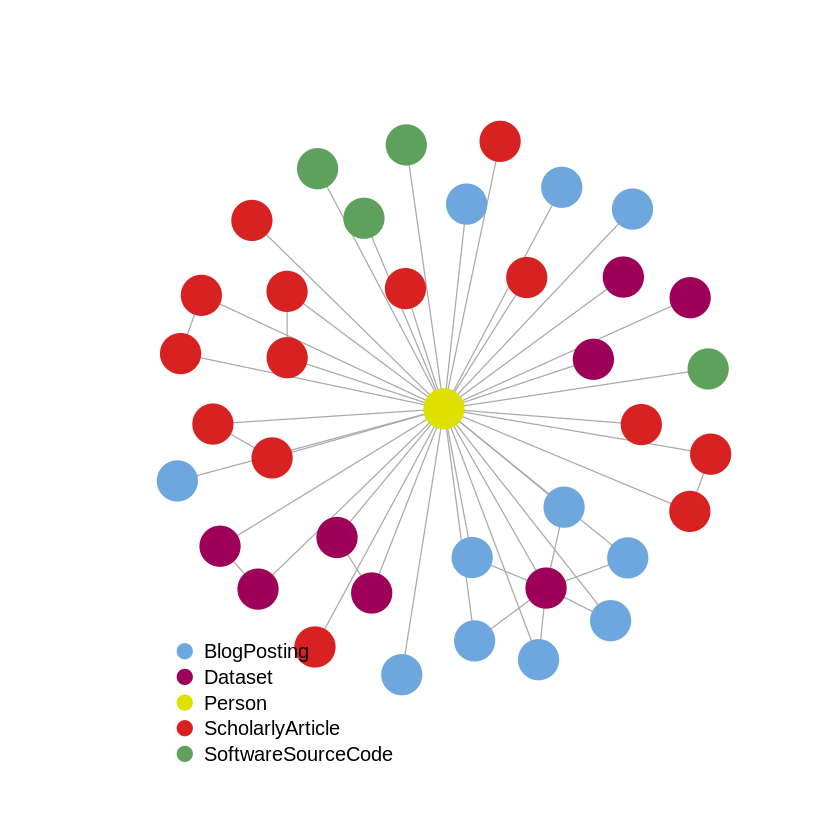

In [10]:
g <-
  graph_from_data_frame(d = my_edges,
                        vertices = my_nodes,
                        directed = FALSE)
#' remove potential loops
g <- igraph::simplify(g)
#' Network Visualisation
#' define node colours
my_palette <-
  c("#6da7de", "#9e0059", "#dee000", "#d82222", "#5ea15d")
my_color <- my_palette[as.numeric(as.factor(V(g)$type))]
#' don't display label
V(g)$label = NA
plot(simplify(g), vertex.color = my_color, 
     vertex.frame.color = my_color,
     arrow.mode = 0)
legend(
  "bottomleft",
  legend = levels(as.factor(V(g)$type)),
  col = my_palette,
  bty = "n",
  pch = 20 ,
  pt.cex = 2.5,
  cex = 1,
  horiz = FALSE,
  inset = c(0.1,-0.1)
)

In [11]:
#' Retrieve Citation Strings from Data Cite
#'
#' @param .data node data.frame where the `name` column represents dois and 
#'        and the `type` column the publication type
#' @param .type column representing the publication type
ref_get <- function(.data = NULL, .type = NULL) {
    doi <- .data %>%
      filter(type  %in% .type) %>%
      mutate(doi = gsub("https://doi.org/", "", name)) %>%
      .$doi %>%
      paste(collapse = ",")
    u <- paste0("https://api.datacite.org/dois?style=apa&page[size]=250&sort=created&ids=", doi)
    resp <- httr::GET(u, accept("text/x-bibliography")) %>%
      httr::content(as = 'text')
  gsub("\n\n", "<br/><br/>", resp)
}
# Call
my_resp <- ref_get(.data = my_nodes, .type = c("ScholarlyArticle", "BlogPost"))
display_markdown("## Publications")
display_html(my_resp)

## Publications

Paglione, L., Rodgers, R., Brand, A., Dolby, K., Fenner, M., Haak, L., … Weinberger, D. (2017). Recommendation of: ORCID Works Metadata Working Group. Figshare . https://doi.org/10.23640/07243.5153971 Burton, A., Fenner, M., Haak, W., & Manghi, P. (2017). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. Zenodo . https://doi.org/10.5281/ZENODO.1120261 Burton, A., Fenner, M., Haak, W., & Manghi, P. (2017). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. Zenodo . https://doi.org/10.5281/ZENODO.1120265 Rous, B., Altman, M., Brand, A., Bilder, G., Ewenstein, J., Fenner, M., … Warner, S. (2018). Committee: ORCID Privacy Committee. Figshare . https://doi.org/10.23640/07243.5984974.V1 Fenner, M. (2018). Open Metrics As Part Of Persistent Identifier Infrastructure. Zenodo . https://doi.org/10.5281/ZENODO.1250025 Vierkant, P., Pampel, H., Elger, K., Kindling, M., Ulrich, R., Witt, M., & Fenner, M. (2018). Status Quo And Perspective Of Re3Data. Zenodo . https://doi.org/10.5281/ZENODO.1297432 Vierkant, P., Pampel, H., Elger, K., Kindling, M., Ulrich, R., Witt, M., & Fenner, M. (2018). Status Quo And Perspective Of Re3Data. Zenodo . https://doi.org/10.5281/ZENODO.1297431 Wimalaratne, S., & Fenner, M. (2018). D2.1 Pid Resolution Services Best Practices. Zenodo . https://doi.org/10.5281/ZENODO.1324300 Wimalaratne, S., & Fenner, M. (2018). D2.1 Pid Resolution Services Best Practices. Zenodo . https://doi.org/10.5281/ZENODO.1324299 Ferguson, C., McEntrye, J., Bunakov, V., Lambert, S., Sandt, S. van der, Kotarski, R., … McCafferty, S. (2018). D3.1 Survey Of Current Pid Services Landscape. Zenodo . https://doi.org/10.5281/ZENODO.1324296 Ferguson, C., McEntrye, J., Bunakov, V., Lambert, S., Sandt, S. van der, Kotarski, R., … McCafferty, S. (2018). D3.1 Survey Of Current Pid Services Landscape. Zenodo . https://doi.org/10.5281/ZENODO.1324295 Witt, M., Stall, S., Duerr, R., Plante, R., Fenner, M., Dasler, R., … Kinkade, D. (2019). Connecting Researchers to Data Repositories in the Earth, Space, and Environmental Sciences. https://doi.org/10.5281/ZENODO.2554875 Witt, M., Stall, S., Duerr, R., Plante, R., Fenner, M., Dasler, R., … Kinkade, D. (2019). Connecting Researchers to Data Repositories in the Earth, Space, and Environmental Sciences. https://doi.org/10.5281/ZENODO.2554874 Ferguson, C., & Fenner, M. (2019). The FREYA project: Collaborating to link people, papers, data, to new things…. Zenodo . https://doi.org/10.5281/ZENODO.3514572

In [12]:
resp <- ref_get(.data = my_nodes, .type = "Dataset")
display_markdown("## Datasets")
display_html(my_resp)

## Datasets

Paglione, L., Rodgers, R., Brand, A., Dolby, K., Fenner, M., Haak, L., … Weinberger, D. (2017). Recommendation of: ORCID Works Metadata Working Group. Figshare . https://doi.org/10.23640/07243.5153971 Burton, A., Fenner, M., Haak, W., & Manghi, P. (2017). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. Zenodo . https://doi.org/10.5281/ZENODO.1120261 Burton, A., Fenner, M., Haak, W., & Manghi, P. (2017). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. Zenodo . https://doi.org/10.5281/ZENODO.1120265 Rous, B., Altman, M., Brand, A., Bilder, G., Ewenstein, J., Fenner, M., … Warner, S. (2018). Committee: ORCID Privacy Committee. Figshare . https://doi.org/10.23640/07243.5984974.V1 Fenner, M. (2018). Open Metrics As Part Of Persistent Identifier Infrastructure. Zenodo . https://doi.org/10.5281/ZENODO.1250025 Vierkant, P., Pampel, H., Elger, K., Kindling, M., Ulrich, R., Witt, M., & Fenner, M. (2018). Status Quo And Perspective Of Re3Data. Zenodo . https://doi.org/10.5281/ZENODO.1297432 Vierkant, P., Pampel, H., Elger, K., Kindling, M., Ulrich, R., Witt, M., & Fenner, M. (2018). Status Quo And Perspective Of Re3Data. Zenodo . https://doi.org/10.5281/ZENODO.1297431 Wimalaratne, S., & Fenner, M. (2018). D2.1 Pid Resolution Services Best Practices. Zenodo . https://doi.org/10.5281/ZENODO.1324300 Wimalaratne, S., & Fenner, M. (2018). D2.1 Pid Resolution Services Best Practices. Zenodo . https://doi.org/10.5281/ZENODO.1324299 Ferguson, C., McEntrye, J., Bunakov, V., Lambert, S., Sandt, S. van der, Kotarski, R., … McCafferty, S. (2018). D3.1 Survey Of Current Pid Services Landscape. Zenodo . https://doi.org/10.5281/ZENODO.1324296 Ferguson, C., McEntrye, J., Bunakov, V., Lambert, S., Sandt, S. van der, Kotarski, R., … McCafferty, S. (2018). D3.1 Survey Of Current Pid Services Landscape. Zenodo . https://doi.org/10.5281/ZENODO.1324295 Witt, M., Stall, S., Duerr, R., Plante, R., Fenner, M., Dasler, R., … Kinkade, D. (2019). Connecting Researchers to Data Repositories in the Earth, Space, and Environmental Sciences. https://doi.org/10.5281/ZENODO.2554875 Witt, M., Stall, S., Duerr, R., Plante, R., Fenner, M., Dasler, R., … Kinkade, D. (2019). Connecting Researchers to Data Repositories in the Earth, Space, and Environmental Sciences. https://doi.org/10.5281/ZENODO.2554874 Ferguson, C., & Fenner, M. (2019). The FREYA project: Collaborating to link people, papers, data, to new things…. Zenodo . https://doi.org/10.5281/ZENODO.3514572

In [13]:
resp <- ref_get(.data = my_nodes, .type = "SoftwareSourceCode")
display_markdown("## Software and Source")
display_html(my_resp)

## Software and Source

Paglione, L., Rodgers, R., Brand, A., Dolby, K., Fenner, M., Haak, L., … Weinberger, D. (2017). Recommendation of: ORCID Works Metadata Working Group. Figshare . https://doi.org/10.23640/07243.5153971 Burton, A., Fenner, M., Haak, W., & Manghi, P. (2017). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. Zenodo . https://doi.org/10.5281/ZENODO.1120261 Burton, A., Fenner, M., Haak, W., & Manghi, P. (2017). Scholix Metadata Schema For Exchange Of Scholarly Communication Links. Zenodo . https://doi.org/10.5281/ZENODO.1120265 Rous, B., Altman, M., Brand, A., Bilder, G., Ewenstein, J., Fenner, M., … Warner, S. (2018). Committee: ORCID Privacy Committee. Figshare . https://doi.org/10.23640/07243.5984974.V1 Fenner, M. (2018). Open Metrics As Part Of Persistent Identifier Infrastructure. Zenodo . https://doi.org/10.5281/ZENODO.1250025 Vierkant, P., Pampel, H., Elger, K., Kindling, M., Ulrich, R., Witt, M., & Fenner, M. (2018). Status Quo And Perspective Of Re3Data. Zenodo . https://doi.org/10.5281/ZENODO.1297432 Vierkant, P., Pampel, H., Elger, K., Kindling, M., Ulrich, R., Witt, M., & Fenner, M. (2018). Status Quo And Perspective Of Re3Data. Zenodo . https://doi.org/10.5281/ZENODO.1297431 Wimalaratne, S., & Fenner, M. (2018). D2.1 Pid Resolution Services Best Practices. Zenodo . https://doi.org/10.5281/ZENODO.1324300 Wimalaratne, S., & Fenner, M. (2018). D2.1 Pid Resolution Services Best Practices. Zenodo . https://doi.org/10.5281/ZENODO.1324299 Ferguson, C., McEntrye, J., Bunakov, V., Lambert, S., Sandt, S. van der, Kotarski, R., … McCafferty, S. (2018). D3.1 Survey Of Current Pid Services Landscape. Zenodo . https://doi.org/10.5281/ZENODO.1324296 Ferguson, C., McEntrye, J., Bunakov, V., Lambert, S., Sandt, S. van der, Kotarski, R., … McCafferty, S. (2018). D3.1 Survey Of Current Pid Services Landscape. Zenodo . https://doi.org/10.5281/ZENODO.1324295 Witt, M., Stall, S., Duerr, R., Plante, R., Fenner, M., Dasler, R., … Kinkade, D. (2019). Connecting Researchers to Data Repositories in the Earth, Space, and Environmental Sciences. https://doi.org/10.5281/ZENODO.2554875 Witt, M., Stall, S., Duerr, R., Plante, R., Fenner, M., Dasler, R., … Kinkade, D. (2019). Connecting Researchers to Data Repositories in the Earth, Space, and Environmental Sciences. https://doi.org/10.5281/ZENODO.2554874 Ferguson, C., & Fenner, M. (2019). The FREYA project: Collaborating to link people, papers, data, to new things…. Zenodo . https://doi.org/10.5281/ZENODO.3514572